# Lambert transfer

This tutorial provides a practical example on how to solve an interplanetary Lambert transfer using Python. A direct and prograde interplanetary transfer arc between the Earth and Mars is solved by using the ``Lambert Profile`` included in Astrogator.

## What is a Lambert transfer?

A Lambert transfer, named after Johann Heinrich Lambert, is a type of orbit transfer used in orbital mechanics. It allows to calculate the trajectory between two orbits under the influence of gravity from a central body, such as a planet or a star.

From the mathematical point of view, a Lambert transfer is the solution of the two-body boundary value problem in the framework of orbital mechanics. This problem is also known as the Lambert’s problem.

Therefore, Lambert’s problem states to find for the Keplerian orbit which connects two known position vectors, $\vec{r_{1}}$ 1 and $\vec{r_{2}}$, over a finite amount of time, $\Delta t$, under a gravity field of gravitational parameter $\mu$.

The first impulse $\Delta v_1$ is performed at $\vec{r_1}$ to inject a spacecraft into a transfer orbit until it reaches $\vec{r_2}$, where a last impulse is performed to achieve the desired final orbit.

It is important to say that perturbations are not considered in this notebook. Only the Keplerian Lambert’s problem is studied. Despite this, STK is capable of using different force models during the propagation of the orbit, allowing for solving the so-called perturbed Lambert's problem.

## Problem statement

Find the Lambert transfer between Earth and Mars starting on August 1, 2005, and ending on March 1, 2006. Assume that the only force acting on the spacecraft is the gravitational force of the Sun. Assume both Earth and Mars are virtual points. Positions of the planets can be obtained using the default ephemerides files provided in STK. Compute the required $\Delta v$ for each impulse of the maneuver.

## Launch a new STK instance

Start by launching a new STK instance. In this example, ``STKEngine`` is used with graphics (``no_graphics`` mode set to ``False``). This means that the graphic user interface (GUI) of the product is not launched but 2D and 3D visualization is still available through the STK Engine controls & Jupyter widgets:

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Next, create a new scenario. The central body for this scenario must be the Sun.

In [2]:
from ansys.stk.core.stkobjects import STKObjectType


root = stk.new_object_root()
scenario = root.children.new_on_central_body(
    STKObjectType.SCENARIO, "LambertTransfer", "Sun"
)

Set the time period for the scenario:

In [3]:
START_TIME, STOP_TIME = "1 Aug 2005", "1 Mar 2006"
scenario.set_time_period(START_TIME, STOP_TIME)

Rewind the scenario to the start time:

In [4]:
root.rewind()

Once created, you can visualize the scenario in a 3D graphics window. Update the value of the far plane of the camera to ensure that distant objects are represented in the scene.

RFBOutputContext()

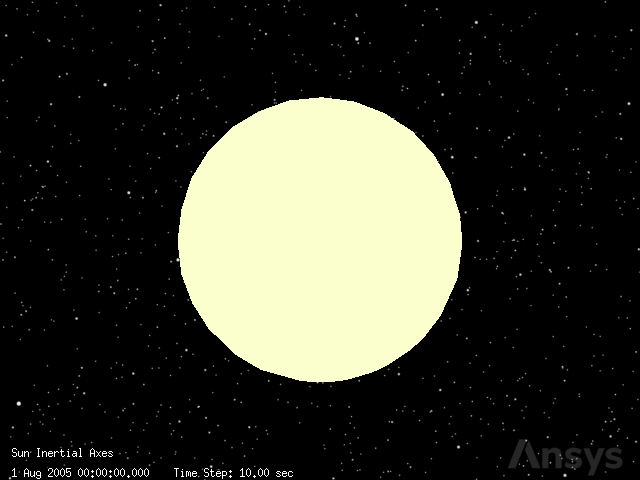

In [5]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


plotter = GlobeWidget(root, 640, 480)
plotter.camera.far_plane = 1e12
plotter.show()

## Add the planets to the scenario

Once the scenario is created, planets can be added. The default ephemerides are used for modeling the orbit of the Earth and Mars. However, it is possible to use other sources for the ephemerides, as provided by the ``EphemSourceType`` enumeration. Finally, a royal blue color is used for representing the Earth while a salmon color is used for Mars.

In [6]:
from ansys.stk.core.stkobjects import (
    EphemSourceType,
    PlanetPositionSourceType,
    STKObjectType,
)
from ansys.stk.core.utilities.colors import Colors


planet_names_and_colors = {
    "Earth": Colors.RoyalBlue,
    "Mars": Colors.Salmon,
}

for planet_name, color in planet_names_and_colors.items():
    planet = scenario.children.new_on_central_body(
        STKObjectType.PLANET, planet_name, "Sun"
    )
    planet.common_tasks.set_position_source_central_body(
        planet_name, EphemSourceType.DEFAULT
    )
    planet.graphics.color = color

Retrieve the instances created for each planet. These are used later for finding the start and final state vectors at the desired epoch:

In [7]:
earth, mars = [scenario.children[planet] for planet in planet_names_and_colors]

Next, the scenario graphics are updated to ensure a nice visualization of the planets:

In [8]:
# General graphics configuration
scenario.graphics.show_label = True

# Vehicle specific graphics
scenario.graphics.show_orbits = True

# Planet specific graphics
scenario.graphics.show_planet_orbits = True
scenario.graphics.show_inertial_position_labels = True
scenario.graphics.show_inertial_position = True
scenario.graphics.show_sub_planet_points = False
scenario.graphics.show_sub_planet_labels = False

Finally, the camera position is updated to provide a better overview of the scene with the planets orbiting the Sun.

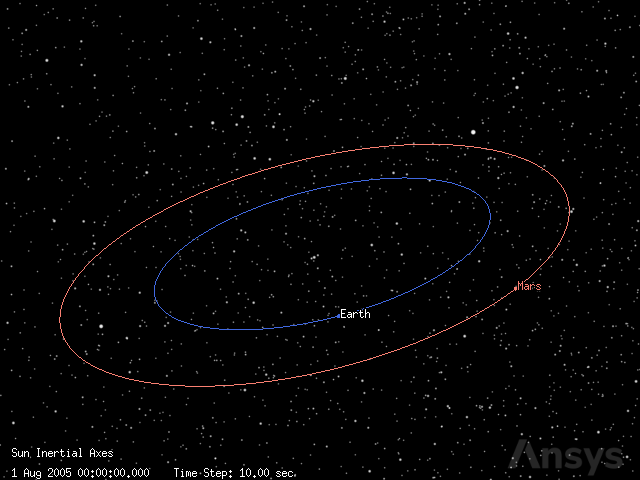

In [9]:
plotter.camera.position = [402322147.89965045, -554001077.0502352, 31332205.857333962]
plotter.show()

## Solve the initial and final state vectors

The initial and final state vectors are required to solve for the transfer orbit. These vectors can be computed knowing the positions of the planets involved in the transfer.

The data providers can be used to find the state vector of an object at a given epoch and with respect to a reference frame.

First, an utility function for converting a ``DataProviderResult`` instance into a Python dictionary is implemented. This allows to easily structure and manipulate the computed values.

In [10]:
def from_data_result_to_dict(data_result: "DataProviderResult") -> dict:
    """Convert a data provider result to a dictionary.

    Parameters
    ----------
    data_result : DataProviderResult
        Data result instance to be converted.

    Returns
    -------
    dict
        Dictionary representing the elements and values of the data provider.

    """
    return {
        key: data_result.data_sets.item(key_id).get_values()
        for key_id, key in enumerate(data_result.data_sets.element_names)
    }

Next, a second utility function is declared. Its goal is to ease the retrieval of the state vector (position and velocity) for an object in the scenario at a given epoch and in the desired reference frame.

In [11]:
def get_object_pos_vel_at_epoch(
    stk_object: "STKObject", epoch: str, frame_name: str
) -> tuple:
    """Compute the position and velocity vectors of an object in the desired reference frame.

    Parameters
    ----------
    stk_object : STKObject
        Name of the object.
    epoch : str
        Epoch in the form of a string.
    frame_name : str
        Reference frame name.

    Returns
    -------
    tuple(list[float, float, float], list[float, float, float])
        Tuple containing the position and velocity vectors as a list.

    """
    state = {"Position": None, "Velocity": None}
    for path in state:
        data_provider = (
            stk_object.data_providers.get_data_provider_time_varying_from_path(
                f"Cartesian {path}/{frame_name}"
            )
        )
        data = from_data_result_to_dict(
            data_provider.execute_single_elements(epoch, ["x", "y", "z"])
        )
        state[path] = [coord[0] for coord in data.values()]
    return tuple(state.values())

Now, it is possible to solve for the initial state:

In [12]:
initial_position, initial_velocity = get_object_pos_vel_at_epoch(
    earth, START_TIME, "ICRF"
)

print(f"Earth position at launch: {initial_position} km")
print(f"Earth position at launch: {initial_velocity} km/s\n")

Earth position at launch: [95104258.7629382, -108600894.17110012, -47083096.083576575] km
Earth position at launch: [22.74785629320743, 17.01595600778551, 7.376576017993339] km/s



And the final state:

In [13]:
final_position, final_velocity = get_object_pos_vel_at_epoch(mars, STOP_TIME, "ICRF")

print(f"Mars position at arrival: {initial_position} km")
print(f"Mars velocity at arrival: {initial_velocity} km/s")

Mars position at arrival: [95104258.7629382, -108600894.17110012, -47083096.083576575] km
Mars velocity at arrival: [22.74785629320743, 17.01595600778551, 7.376576017993339] km/s


## Add a satellite to the scenario

Once the initial and final states are known, it is time to add a new satellite to the scenario. This object is used to simulate the transfer orbit between Earth and Mars at the desired launch and arrival dates.

The central body for the satellite must be the Sun to be compliant with the Keplerian assumption of the Lambert transfer. Remember that the gravity for Earth and Mars are ignored in this example.

In [14]:
satellite = root.current_scenario.children.new_on_central_body(
    STKObjectType.SATELLITE, "Satellite", "Sun"
)

Then, indicate the type of propagator used for the satellite. In this case, the propagator must be astrogator.

In [15]:
from ansys.stk.core.stkobjects import PropagatorType


satellite.set_propagator_type(PropagatorType.ASTROGATOR)

Remove all the main sequence to ensure no prior segments lead to wrong results during the simulation.

In [16]:
satellite.propagator.main_sequence.remove_all()

## Declare the initial state of the satellite

Now, declare the initial state of the satellite by using an initial state segment.

In [17]:
from ansys.stk.core.stkobjects.astrogator import ElementSetType, SegmentType


initial_state = satellite.propagator.main_sequence.insert(
    SegmentType.INITIAL_STATE, "Initial State", "-"
)

Use an inertial reference frame when declaring the initial state. Also, ensure that the epoch matches the launch date.

In [18]:
initial_state.coord_system_name = "CentralBody/Sun Inertial"
initial_state.orbit_epoch = START_TIME

 The value of the initial state must match the initial state of the Earth. Cartesian elements are used in this case.

In [19]:
initial_state.set_element_type(ElementSetType.CARTESIAN)

initial_state.element.x = initial_position[0]
initial_state.element.y = initial_position[1]
initial_state.element.z = initial_position[2]

initial_state.element.vx = initial_velocity[0]
initial_state.element.vy = initial_velocity[1]
initial_state.element.vz = initial_velocity[2]

## Construct the transfer sequence

The transfer sequence can be modeled as a target sequence containing three segments: a first impulsive maneuver, a propagation, and a last impulsive maneuver.

In [20]:
from ansys.stk.core.stkobjects.astrogator import ManeuverType


lambert_transfer = satellite.propagator.main_sequence.insert(
    SegmentType.TARGET_SEQUENCE, "Lambert Transfer", "-"
)

first_impulse = lambert_transfer.segments.insert(
    SegmentType.MANEUVER, "First Impulse", "-"
)
propagate = lambert_transfer.segments.insert(SegmentType.PROPAGATE, "Propagate", "-")
last_impulse = lambert_transfer.segments.insert(
    SegmentType.MANEUVER, "Last Impulse", "-"
)

Next, configure the maneuvers to be impulsive and ensure the propagation models the Sun as a point mass.

In [21]:
first_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)
propagate.propagator_name = "Sun Point Mass"
last_impulse.set_maneuver_type(ManeuverType.IMPULSIVE)

Then, remove any previous profiles that could be present in the target sequence:

In [22]:
lambert_transfer.profiles.remove_all()

Finally, it is possible to visualize the layout for the main sequence by running:

In [23]:
for control_sequence in satellite.propagator.main_sequence:
    try:
        print(f"{control_sequence.name}")
        for segment in control_sequence.segments:
            print(f"    {segment.name}")
    except:
        continue

Initial State
Lambert Transfer
    First Impulse
    Propagate
    Last Impulse
    -
-


## Configure the Lambert profile

To ease the creation of a Lambert's transfer, STK provides a profile named ``IProfileLambertProfile``. This profile can be added to a target sequence. Later, it can be configured to solve for the desired transfer requirements such as the time of flight and the final state vector.

Additional configuration parameters exist, such as the number of revolutions or the direction of motion. However, since this example covers a direct transfer arc, these options are not explored.

Start by adding a Lambert profile to the target sequence:

In [24]:
lambert = lambert_transfer.profiles.add("Lambert Profile")

Next, declare the target state vector. In this case, the target state vector is the final state vector. This vector is defined in an inertial reference frame centered at the Sun. Cartesian coordinates are used for the components of the position and velocity.

It is also important to enable the second maneuver property. This allows to specify the target velocity.

In [25]:
from ansys.stk.core.stkobjects.astrogator import LambertTargetCoordinateType


lambert.coord_system_name = "CentralBody/Sun Inertial"
lambert.set_target_coord_type(LambertTargetCoordinateType.CARTESIAN)

lambert.enable_second_maneuver = True

# TODO: the Lambert Profile does not respect user defined units.
# https://github.com/ansys/pystk/issues/439
lambert.target_position_x = final_position[0] * 1000
lambert.target_position_y = final_position[1] * 1000
lambert.target_position_z = final_position[2] * 1000

lambert.target_velocity_x = final_velocity[0] * 1000
lambert.target_velocity_y = final_velocity[1] * 1000
lambert.target_velocity_z = final_velocity[2] * 1000

Next, the time of flight can be computed. Using the `datetime` module allows for the computation of the time of flight, which is assigned later to the Lambert profile.

In [26]:
launch_date = root.conversion_utility.new_date("UTCG", START_TIME)
arrival_date = root.conversion_utility.new_date("UTCG", STOP_TIME)
tof = arrival_date.span(launch_date).value

lambert.time_of_flight = tof
print(f"Time of flight: {tof} seconds")

Time of flight: 18316801.0 seconds


Then, other parameters for the transfer can be configured. These include the type of solution, the direction of motion, and the padding altitude for the collision with the central body.

**Since planets are modeled as points, see the problem statement, the value for the altitude padding for the central body collision is 0 km.**

In [27]:
from ansys.stk.core.stkobjects.astrogator import (
    LambertDirectionOfMotionType,
    LambertSolutionOptionType,
)


lambert.solution_option = LambertSolutionOptionType.FIXED_TIME
lambert.revolutions = 0
lambert.direction_of_motion = LambertDirectionOfMotionType.SHORT

# TODO: the Lambert Profile does not respect user defined units.
# https://github.com/ansys/pystk/issues/439
lambert.central_body_collision_altitude_padding = 0

It is required to enable writing access to the lambert profile to the segments of the target sequence. This ensures that the control parameter values are modified to match the target values.

In [28]:
lambert.enable_write_to_first_maneuver = True
lambert.first_maneuver_segment = first_impulse.name

lambert.enable_write_duration_to_propagate = True
lambert.disable_non_lambert_propagate_stop_conditions = True
lambert.propagate_segment = propagate.name

lambert.enable_write_to_second_maneuver = True
lambert.second_maneuver_segment = last_impulse.name

## Run the main control sequence

Once the whole control sequence is declared and the Lambert profile active, the simulation can be performed. Ensure that the Lambert profile is active and that the mission control sequence runs all active profiles. In addition, any profile must run to return and continue once finished. Do not continue on failure or reset inner targeters.

In [29]:
from ansys.stk.core.stkobjects.astrogator import (
    ProfileMode,
    ProfilesFinish,
    TargetSequenceAction,
)


lambert.mode = ProfileMode.ACTIVE

lambert_transfer.action = TargetSequenceAction.RUN_ACTIVE_PROFILES
lambert_transfer.when_profiles_finish = ProfilesFinish.RUN_TO_RETURN_AND_CONTINUE

lambert_transfer.continue_on_failure = False
lambert_transfer.reset_inner_targeters = False

Finally, run the mission control sequence and apply the results to all profiles. Note that in this case, the only existing profile is the `Lambert Profile`.

In [30]:
satellite.propagator.run_mcs()
satellite.propagator.apply_all_profile_changes()

## Retrieve the results

Now, the results can be retrieved. The value of the increment in velocity magnitude for the first and last impulse are computed. Also, the $C_{3}$ values for the characteristic departure and arrival energy are solved.

In [31]:
# TODO: the Lambert Profile does not respect user defined units.
# https://github.com/ansys/pystk/issues/439
delta_v1 = first_impulse.maneuver.attitude_control.magnitude / 1000
c3_launch = delta_v1**2

print(f"First impulse: {delta_v1:.2f} km/s")
print(f"C3 at launch: {c3_launch:.2f} km2/s2")

First impulse: 4.19 km/s
C3 at launch: 17.60 km2/s2


In [32]:
# TODO: the Lambert Profile does not respect user defined units.
# https://github.com/ansys/pystk/issues/439
delta_v2 = last_impulse.maneuver.attitude_control.magnitude / 1000
c3_arrival = delta_v2**2

print(f"Last impulse:  {delta_v2:.2f} km/s")
print(f"C3 at arrival: {c3_arrival:.2f} km2/s2")

Last impulse:  3.10 km/s
C3 at arrival: 9.62 km2/s2


## Visualize the transfer

Finally, animate the scene to visualize the transfer orbit. Ensure the satellite is visible by updating the detail threshold of its three-dimensional model and forcing STK to draw its trajectory:

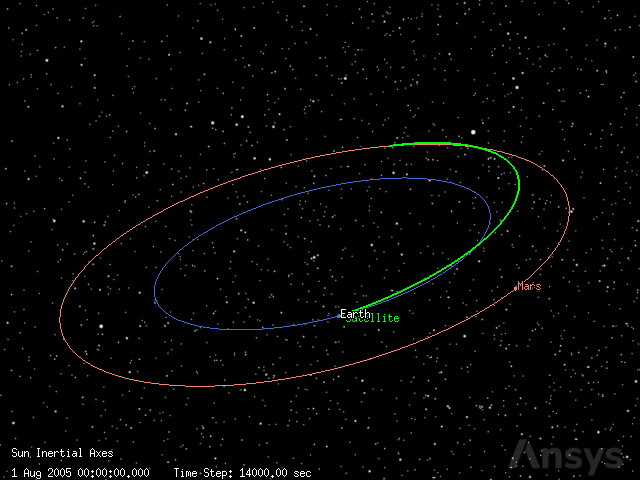

In [33]:
satellite.propagator.options.draw_trajectory_in_3d = True
satellite.graphics_3d.model.detail_threshold.all = 1e12

plotter.animate(time_step=14000)
plotter.show()